In [16]:
import requests

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

In [13]:
api_key = '54a7a1cdc5b64df89cd804dea504bbc3'

In [2]:
census_tract_path = '/Users/carlo/Downloads/geo_data/us_tracts/us_tract.shp'

In [3]:
tracts = gpd.read_file(census_tract_path)

In [4]:
print(tracts.shape)
tracts.head(2)

(74101, 14)


,region_id,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,44003022400,44,3,22400,44003022400,224.00,Census Tract 224,G5020,S,6636437,6446407,41.658322,-71.426914,"POLYGON ((-71.46854 41.63864, -71.46774 41.638..."
1,32003003612,32,3,3612,32003003612,36.12,Census Tract 36.12,G5020,S,2727271,0,36.224649,-115.198176,"POLYGON ((-115.20755 36.22450, -115.20754 36.2..."


In [11]:
coords = tracts[tracts['region_id'].str.startswith('36061')].centroid
xs = coords.apply(lambda x: x.x).tolist()
ys = coords.apply(lambda x: x.y).tolist()

<ipython-input-11-cc7c2a2c1f5f>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = tracts[tracts['region_id'].str.startswith('36061')].centroid


In [20]:
url = 'https://api.breezometer.com/air-quality/v2/historical/hourly?lat=%s&lon=%s&key=%s&datetime=2021-02-23T00:00:00' % (ys[0], xs[0], api_key)


In [21]:
r = requests.get(url)

In [22]:
features = r.json()

In [25]:
features

{'metadata': None,
 'data': {'datetime': '2021-02-23T00:00:00Z',
  'data_available': True,
  'indexes': {'baqi': {'display_name': 'BreezoMeter AQI',
    'aqi': 78,
    'aqi_display': '78',
    'color': '#60C134',
    'category': 'Good air quality',
    'dominant_pollutant': 'no2'}}},
 'error': None}

In [32]:
results = []

for ix in range(len(ys)):
    url = 'https://api.breezometer.com/air-quality/v2/historical/hourly?lat=%s&lon=%s&key=%s&datetime=2021-02-23T00:00:00' \
        % (ys[ix], xs[ix], api_key)
    r = requests.get(url)
    features = r.json()
    features['data']['indexes']['baqi']
    results.append(
        {'aqi': features['data']['indexes']['baqi']['aqi'],
         'color': features['data']['indexes']['baqi']['color'],
         'category': features['data']['indexes']['baqi']['category'],
         'pollutant': features['data']['indexes']['baqi']['dominant_pollutant']}
    )

In [34]:
df = pd.DataFrame(results)

In [35]:
df['lat'] = ys
df['lng'] = xs

In [46]:
df['region_id'] = tracts['region_id'].loc[tracts['region_id'].str.startswith('36061')].tolist()

In [38]:
df.shape

(288, 6)

In [48]:
df.head()

,aqi,color,category,pollutant,lat,lng,region_id
0,78,#60C134,Good air quality,no2,40.722673,-73.969787,36061002400
1,67,#96D62B,Good air quality,pm10,40.762604,-73.972131,36061011202
2,69,#8AD130,Good air quality,pm10,40.728956,-73.971355,36061004400
3,70,#84CF33,Good air quality,no2,40.721711,-74.014607,36061003900
4,78,#60C134,Good air quality,no2,40.732164,-73.970268,36061006000


<AxesSubplot:>

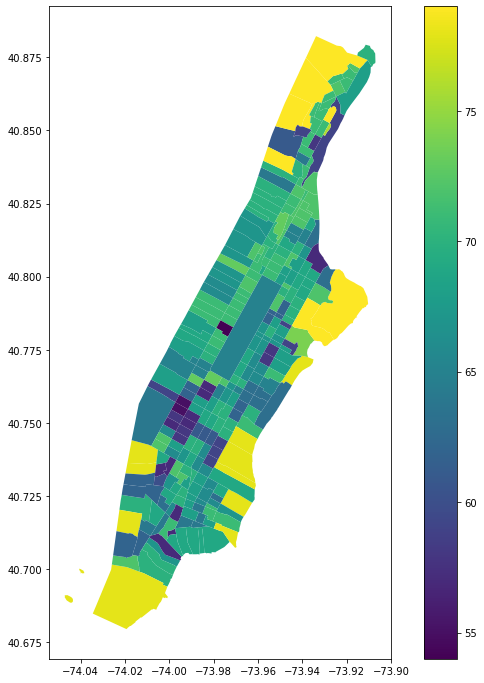

In [51]:
tracts.merge(df, on='region_id').plot(column='aqi', figsize=(12, 12), legend=True)